In [1]:
import torch
import os
from PIL import Image
from diffusers.models.attention_processor import FluxAttnProcessor2_0
import matplotlib.pyplot as plt

from src.pipeline import RFInversionParallelFluxPipeline
from src.attn_processor import PersonalizeAnythingAttnProcessor, set_flux_transformer_attn_processor
from src.utils import *

/data/hzw/.conda/envs/t2i/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
device = torch.device("cuda")
generator = torch.Generator(device=device).manual_seed(18)
torch_type = torch.float16
timestep = 28

DIT_MODEL = "black-forest-labs/FLUX.1-dev"
pipe = RFInversionParallelFluxPipeline.from_pretrained(DIT_MODEL, torch_dtype=torch_type).to(device)

height = 1024
width = 1024
latent_h = height // (pipe.vae_scale_factor * 2)
latent_w = width // (pipe.vae_scale_factor * 2)
img_dims = latent_h * latent_w

Loading pipeline components...: 100%|██████████| 7/7 [00:05<00:00,  1.20it/s]


## Inpainting

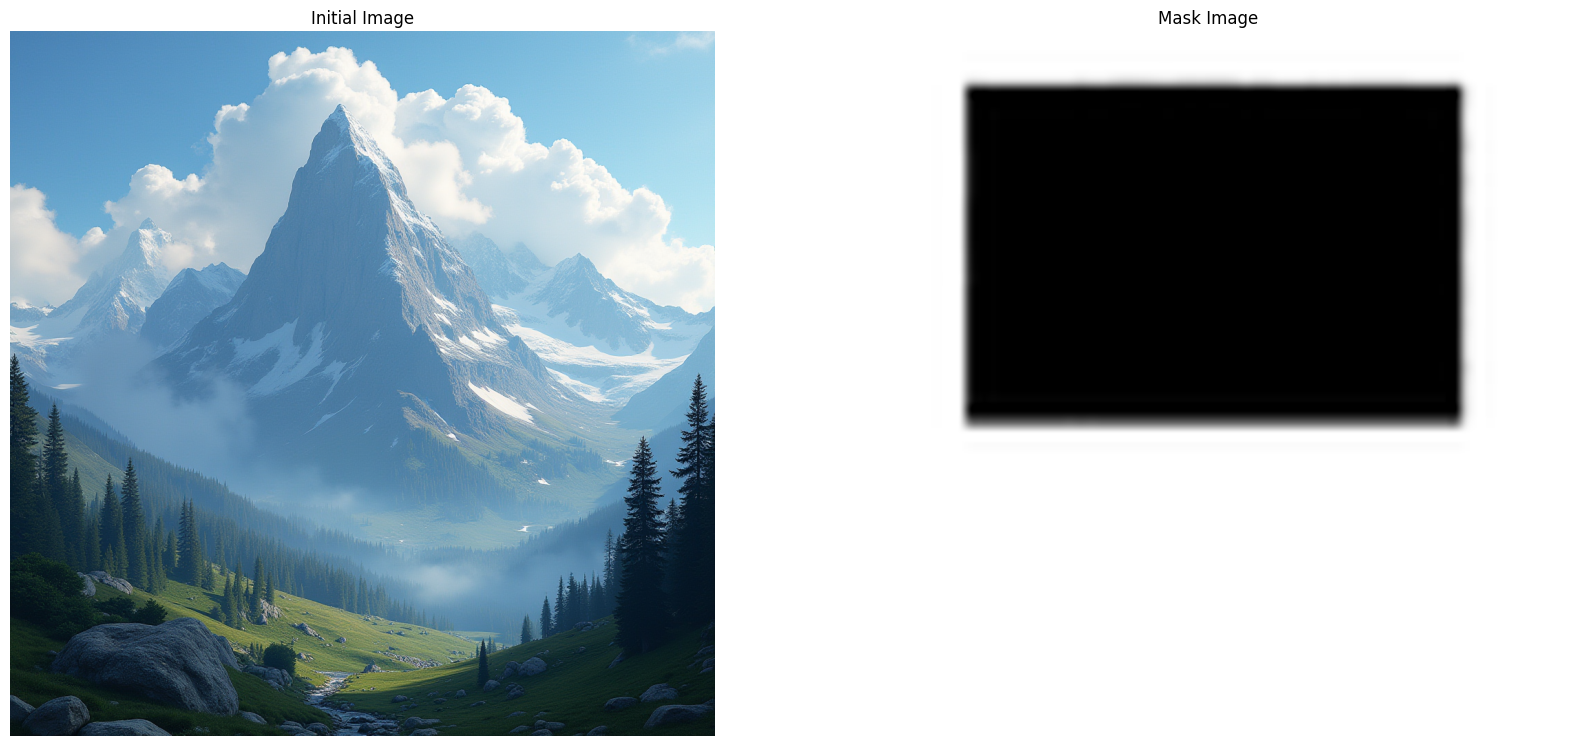

In [3]:
prompt = "A mountain"
key_word = "mountain"
new_prompt = "On the top of a mountain, there is a European-style castle."
tau = 45
shift = 0   # The shift should adjust with the image size; otherwise, it may overflow.

key_word_path = key_word.replace(" ", "_")
root_dir = os.path.join("example_data", key_word_path)

# show original image
init_image_path = os.path.join(root_dir, "background.png")
init_image = Image.open(init_image_path).convert('RGB').resize((width, height))

# show mask
mask_path = os.path.join(root_dir, "mask.png")
mask = create_mask(mask_path, latent_w, latent_h)
shift_mask = shift_tensor(mask, shift)    
img_mask = Image.open(mask_path).convert('RGB').resize((width, height))


fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(init_image)
axes[0].axis("off")
axes[0].set_title("Initial Image")

axes[1].imshow(img_mask)
axes[1].axis("off")
axes[1].set_title("Mask Image")

plt.show() # show input conditions

  0%|          | 0/28 [00:00<?, ?it/s]/data/hzw/projects_fhr/personalize-anything/src/pipeline.py:1059: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  timestep = torch.tensor(t_i, dtype=Y_t.dtype, device=device).repeat(batch_size)
100%|██████████| 28/28 [00:33<00:00,  1.21s/it]


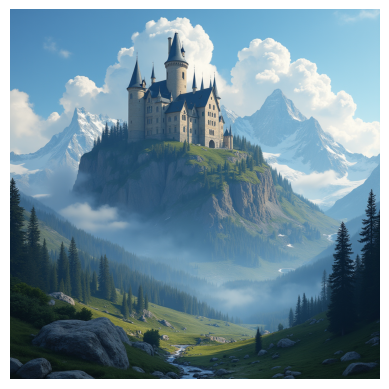

In [4]:
inverted_latents, image_latents, latent_image_ids = pipe.invert( 
    source_prompt="", 
    image=init_image, 
    height=height,
    width=width,
    num_inversion_steps=timestep, 
    gamma=1.0)

set_flux_transformer_attn_processor(
    pipe.transformer,
    set_attn_proc_func=lambda name, dh, nh, ap: PersonalizeAnythingAttnProcessor(
        name=name, tau=tau/100, mask=mask, shift_mask=shift_mask, device=device, img_dims=img_dims),
)

image = pipe(
    [prompt, new_prompt], 
    inverted_latents=inverted_latents,
    image_latents=image_latents,
    latent_image_ids=latent_image_ids,
    height = height,
    width = width,
    start_timestep=0.0, 
    stop_timestep=0.99,
    num_inference_steps=timestep,
    eta=1.0, 
    generator=generator,
).images[1]

plt.imshow(image)
plt.axis("off")
plt.show() # show output image

## Outpainting

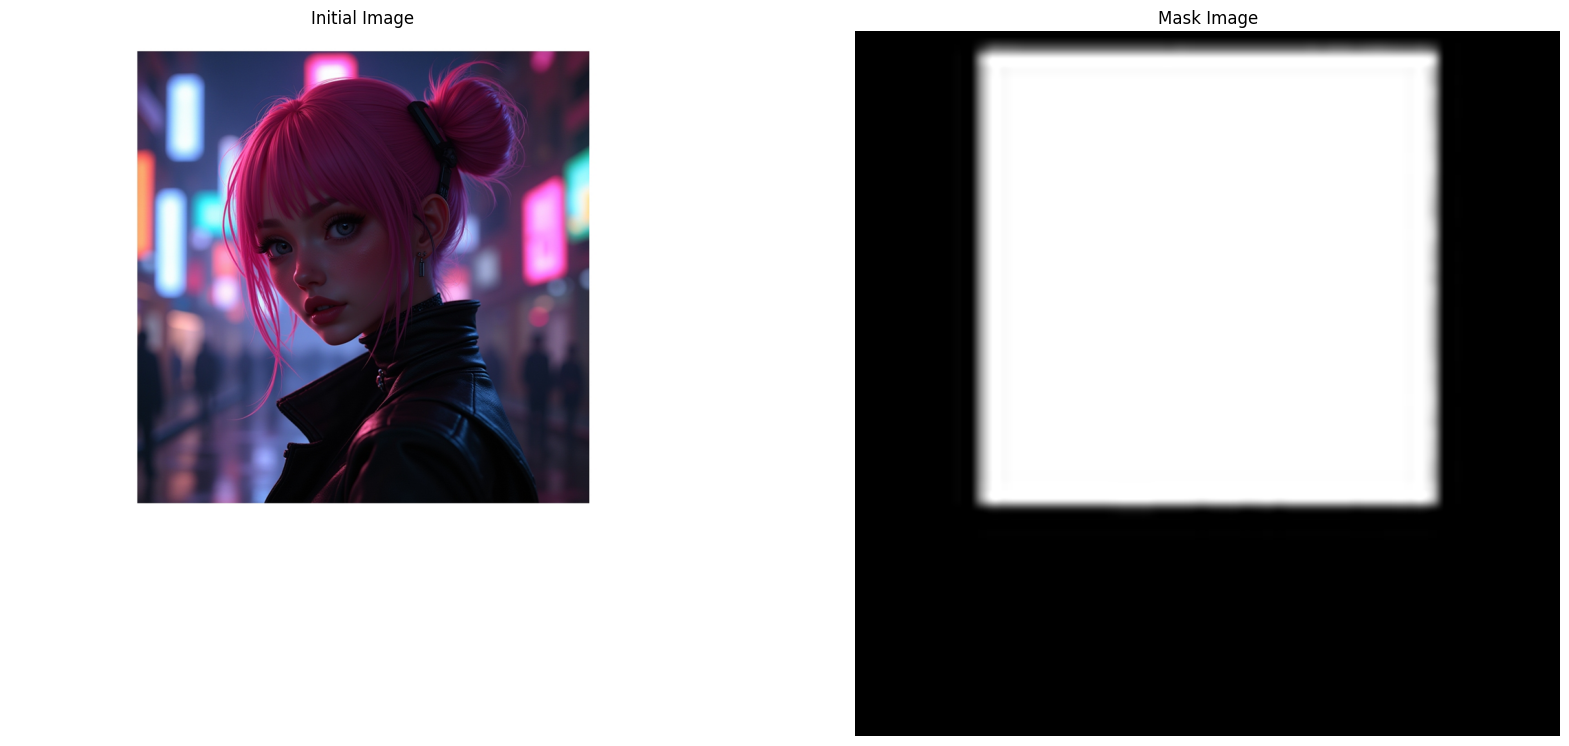

In [5]:
prompt = "A cyberpunk-style girl."
key_word = "cyberpunk"
new_prompt = "A cyberpunk-style girl, with a background of a futuristic city illuminated by flickering neon lights."
tau = 70
shift = 0

key_word_path = key_word.replace(" ", "_")
root_dir = os.path.join("example_data", key_word_path)

# show original image
init_image_path = os.path.join(root_dir, "background.png")
init_image = Image.open(init_image_path).convert('RGB').resize((width, height))

# show mask
mask_path = os.path.join(root_dir, "mask.png")
mask = create_mask(mask_path, latent_w, latent_h)
shift_mask = shift_tensor(mask, shift)    
img_mask = Image.open(mask_path).convert('RGB').resize((width, height))


fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(init_image)
axes[0].axis("off")
axes[0].set_title("Initial Image")

axes[1].imshow(img_mask)
axes[1].axis("off")
axes[1].set_title("Mask Image")

plt.show() # show input conditions

  0%|          | 0/28 [00:00<?, ?it/s]/data/hzw/projects_fhr/personalize-anything/src/pipeline.py:1059: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  timestep = torch.tensor(t_i, dtype=Y_t.dtype, device=device).repeat(batch_size)
100%|██████████| 28/28 [00:33<00:00,  1.19s/it]


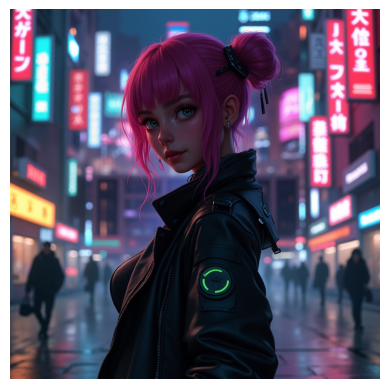

In [6]:
set_flux_transformer_attn_processor(pipe.transformer, set_attn_proc_func=lambda name, dh, nh, ap:FluxAttnProcessor2_0())
inverted_latents, image_latents, latent_image_ids = pipe.invert( 
    source_prompt="", 
    image=init_image, 
    height=height,
    width=width,
    num_inversion_steps=timestep, 
    gamma=1.0)

set_flux_transformer_attn_processor(
    pipe.transformer,
    set_attn_proc_func=lambda name, dh, nh, ap: PersonalizeAnythingAttnProcessor(
        name=name, tau=tau/100, mask=mask, shift_mask=shift_mask, device=device, img_dims=img_dims),
)

image = pipe(
    [prompt, new_prompt], 
    inverted_latents=inverted_latents,
    image_latents=image_latents,
    latent_image_ids=latent_image_ids,
    height = height,
    width = width,
    start_timestep=0.0, 
    stop_timestep=0.99,
    num_inference_steps=timestep,
    eta=1.0, 
    generator=generator,
).images[1]

plt.imshow(image)
plt.axis("off")
plt.show() # show output image